In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from os.path import join
import Pk_library as PKL
import h5py
os.chdir('/home/mattho/git/ltu-cmass/matts_tests')
mpl.style.use('./style.mcstyle')


In [2]:
from cmass.utils import get_source_path

wdir = '/home/mattho/git/ltu-cmass/data/'

### Comparing $z=0.5$ quijote, pmwd, fastpm
Configuration: lhid=3, B=2, SS=3

In [3]:
lhid=3
af= 1/(1+0.5) # 1

from cmass.utils import load_params
cosmo = load_params(lhid, '../params/latin_hypercube_params.txt')

In [13]:
# Load pmwd
suite = 'quijotelike'
sim = 'pmwd'
L, N = 1000, 128

source_path = get_source_path(wdir, suite, sim, L, N, lhid)
with h5py.File(join(source_path, 'nbody.h5')) as f:
    prho = f[f'{af:.6f}']['rho'][...]

In [14]:
# Load fastpm
suite = 'quijotelike'
sim = 'fastpm'
L, N = 1000, 128

source_path = get_source_path(wdir, suite, sim, L, N, lhid)
with h5py.File(join(source_path, 'nbody.h5')) as f:
    frho = f[f'{af:.6f}']['rho'][...]

In [15]:
# # Load quijote
# rho_path = join('/automnt/data80/mattho/quijote/density_field/latin_hypercube',
#                 str(lhid), 'df_m_128_z=0.npy')
# qrho = np.load(rho_path)

In [16]:
# Load Quijote snapshot

import numpy as np
import MAS_library as MASL

snapshot = 'snapdir_003/snap_003'  #snapshot name
snapshot = join('/automnt/data80/mattho/quijote/Snapshots/latin_hypercube/', str(lhid), snapshot)
grid     = 128                     #grid size
ptypes   = [1]                     #CDM
MAS      = 'CIC'                   #Cloud-in-Cell
do_RSD   = False                   #dont do redshif-space distortions
axis     = 0                       #axis along which place RSD; not used here
verbose  = True   #whether print information on the progress

# Compute the effective number of particles/mass in each voxel
delta = MASL.density_field_gadget(snapshot, ptypes, grid, MAS, do_RSD, axis, verbose)

# compute density contrast: delta = rho/<rho> - 1
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0
qrho = delta


Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 8.26 seconds


Text(0.5, 0.98, '$z=0.5$ Density Field')

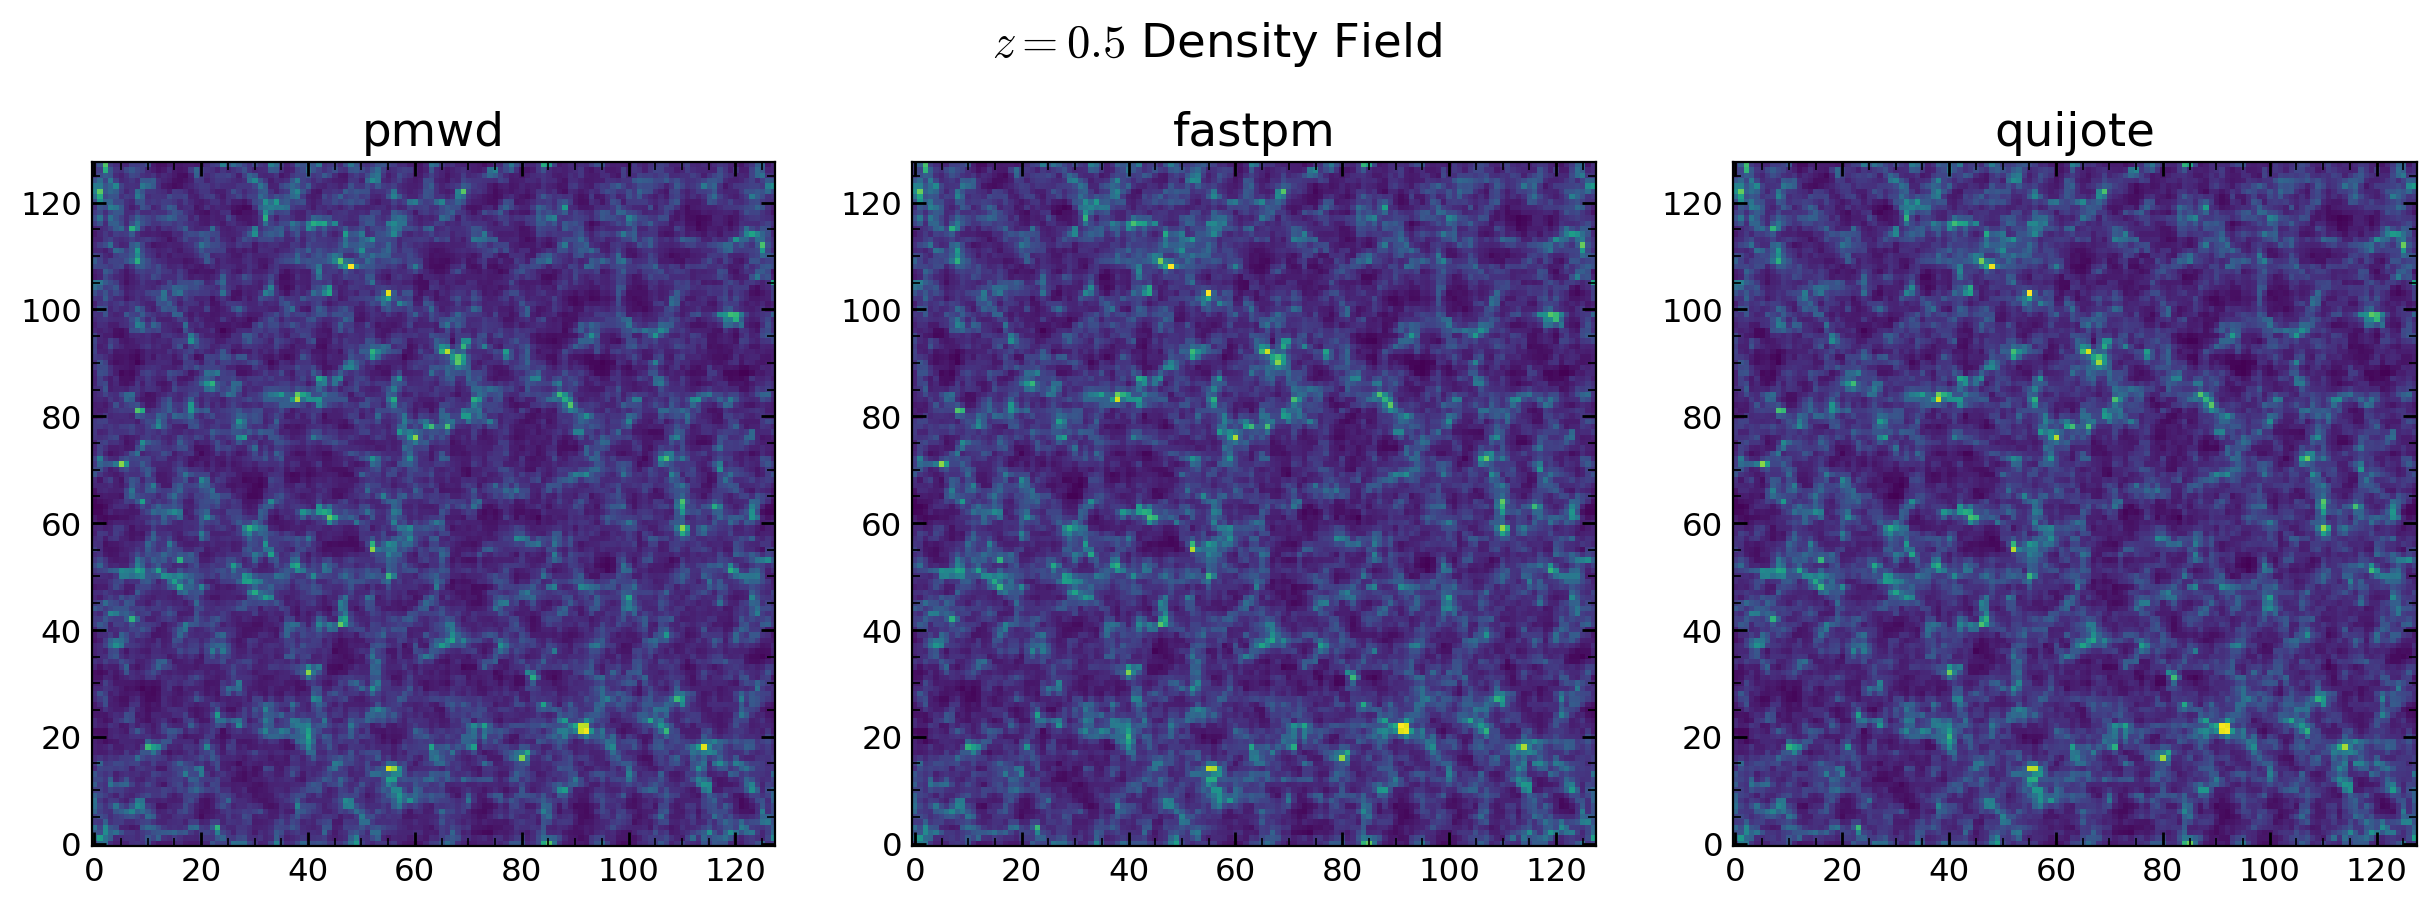

In [17]:
# Plot a slice
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, rho, title in zip(axs, [prho, frho, qrho], ['pmwd', 'fastpm', 'quijote']):
    ax.imshow(rho[:, :, 60:70].mean(axis=-1), origin='lower', cmap='viridis')
    ax.set_title(title)
fig.suptitle(r'$z=0.5$ Density Field')

In [18]:
prho.mean(), frho.mean(), qrho.mean()

(-3.5397534e-08, 3.517198e-08, -1.0186341e-10)

Text(0, 0.5, '$P(k)/P(k)_{\\rm quijote}$')

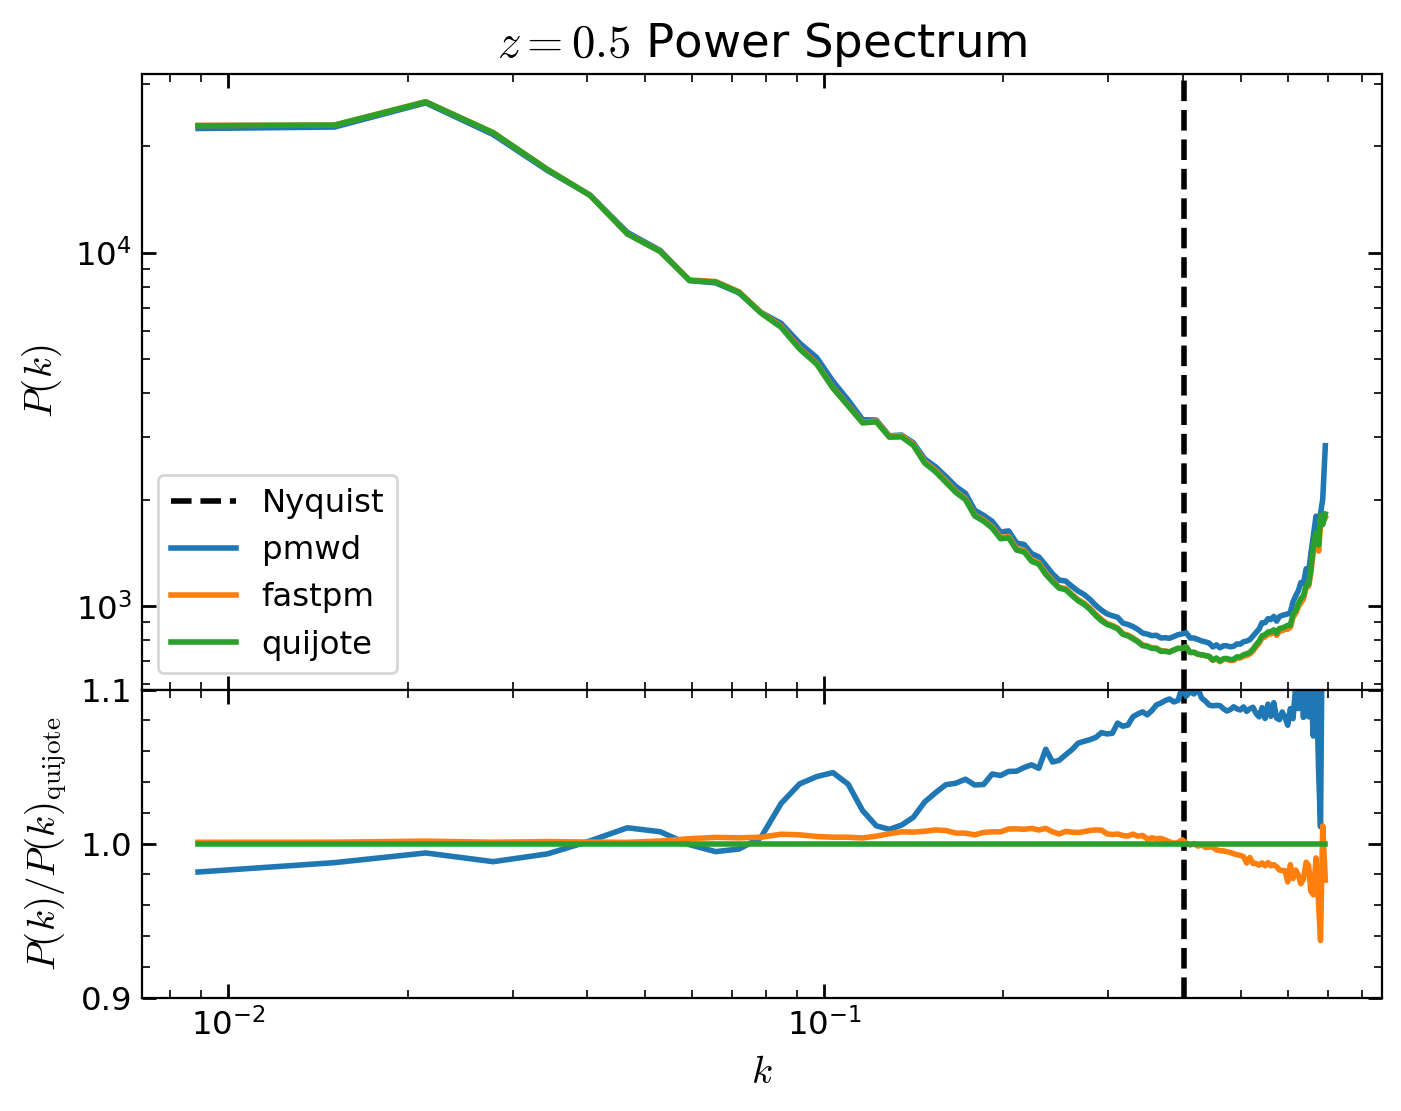

In [20]:
import Pk_library as PKL

def compute_pk(rho):
    pk = PKL.Pk(rho, BoxSize=1000, axis=0, MAS='CIC', threads=1, verbose=False)
    return pk.k3D, pk.Pk[:, 0]

k, pkp = compute_pk(prho)
k, pkf = compute_pk(frho)
k, pkq = compute_pk(qrho)
knyq = np.pi * N / L

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6),
                        gridspec_kw={'height_ratios': [2, 1], 'hspace':0})

ax = axs[0]
ax.loglog()
ax.axvline(knyq, color='k', ls='--', label='Nyquist')
ax.plot(k, pkp, label='pmwd')
ax.plot(k, pkf, label='fastpm')
ax.plot(k, pkq, label='quijote')
ax.legend()
ax.set_title(r'$z=0.5$ Power Spectrum')
ax.set_ylabel(r'$P(k)$')

ax = axs[1]
ax.axvline(knyq, color='k', ls='--', label='Nyquist')
ax.plot(k, pkp/pkq, label='pmwd/quijote')
ax.plot(k, pkf/pkq, label='fastpm/quijote')
ax.plot(k, pkq/pkq, label='quijote/quijote')
ax.set_xlabel(r'$k$')
ax.set_ylim(0.9, 1.1)
ax.set_ylabel(r'$P(k)/P(k)_{\rm quijote}$')